In [ ]:
##Computing SNP pair-linkage w/in and between clusters - Figure S5

Get general patterns of SNP-pair linkage within and between clusters

In [1]:
source("/home/users/mcbitter/OrchardProject/Code/config.R")
source("/home/users/mcbitter/OrchardProject/Code/helper_functions.R")
source("/home/users/mcbitter/OrchardProject/Code/load_packages.R")
source("/home/users/mcbitter/OrchardProject/Code/plotting_functions.R")
source("/home/users/mcbitter/OrchardProject/Code/workflow_functions.R")
source("/home/users/mcbitter/OrchardProject/Code/general_cage_functions.R")
source("/home/users/mcbitter/OrchardProject/Code/Orchard2021_Scripts/LOA/loa.orch2021.functions.R")
setwd('~/dpetrov/MarkB/Orchard2021Data/19_ClusterCovariance/')

In [ ]:
dist.cntrl = df.d %>% dplyr::select(snp.pos.dist, Rsq.pos.cntrl)
names(dist.cntrl) = c('dist','Rsq')
dist.cntrl  = dist.cntrl %>% mutate(dist = dist/1000000)

dist.comp = df.d %>% dplyr::select(snp.comp.dist, Rsq.comparison)
names(dist.comp) = c('dist','Rsq')
dist.comp  = dist.comp %>% mutate(dist = dist/1000000)

In [15]:
#1) Read in file containing focal SNP w/ pairs w/in and btwn clusters 
df = read.csv('./SNPPairRSq.Meta.csv')


In [21]:
#2) select the control (within cluster) comparisons and Rsq values, and the between (comparison) comparisons
dist.cntrl = df %>% dplyr::select(snp.pos.dist, Rsq.pos.cntrl)
names(dist.cntrl) = c('dist','Rsq')
dist.cntrl  = dist.cntrl %>% mutate(dist = dist/1000000)
dist.cntrl = na.omit(dist.cntrl)

dist.comp = df %>% dplyr::select(snp.comp.dist, Rsq.comparison)
names(dist.comp) = c('dist','Rsq')
dist.comp  = dist.comp %>% mutate(dist = dist/1000000)
dist.comp = na.omit(dist.comp)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 1447 rows containing non-finite values (`stat_smooth()`).”
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 1447 rows containing non-finite values (`stat_smooth()`).”


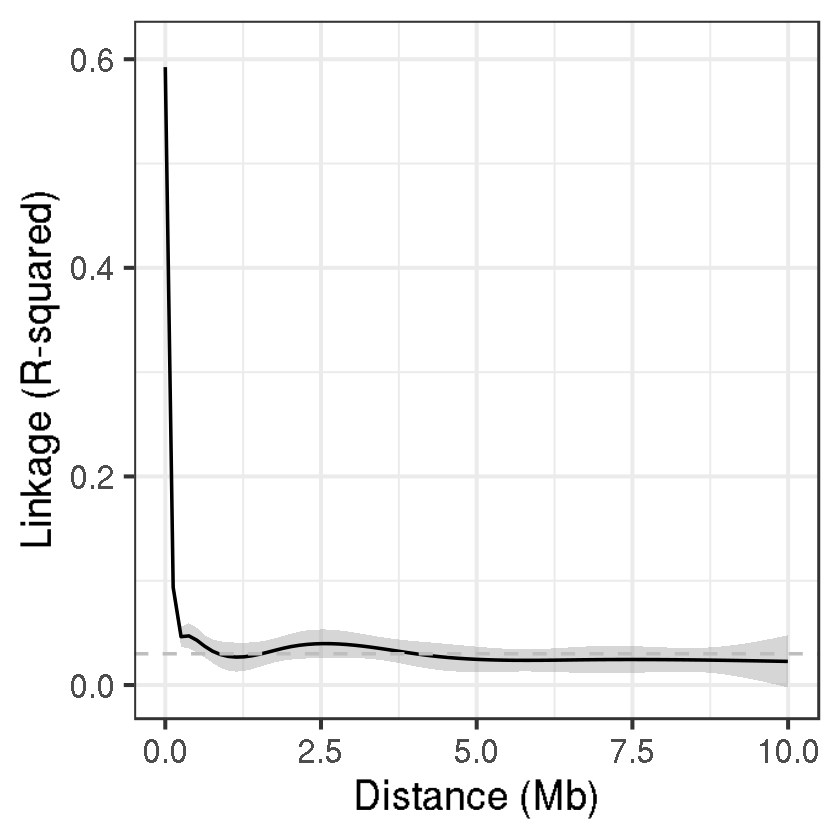

In [31]:
#Create meta data w/ both within and between clusters (on same chromosome)
dist = rbind(dist.cntrl, dist.comp)
p = ggplot(na.omit(dist) %>% sample_n(10000), aes(x = dist, y = Rsq)) +
    geom_smooth(colour = 'black') +
    xlim(0,10) +
    ylab('Linkage (R-squared)') +
    theme_bw(base_size = 25) +
    xlab('Distance (Mb)') +
    geom_hline(yintercept = 0.03, linetype = 'dashed', colour = 'grey', size = 1)
p
ggsave( '../Figures/ClusterLinkage/Linkage.Meta.pdf', p, width = 10, height = 10)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 10 rows containing non-finite values (`stat_smooth()`).”
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 10 rows containing non-finite values (`stat_smooth()`).”


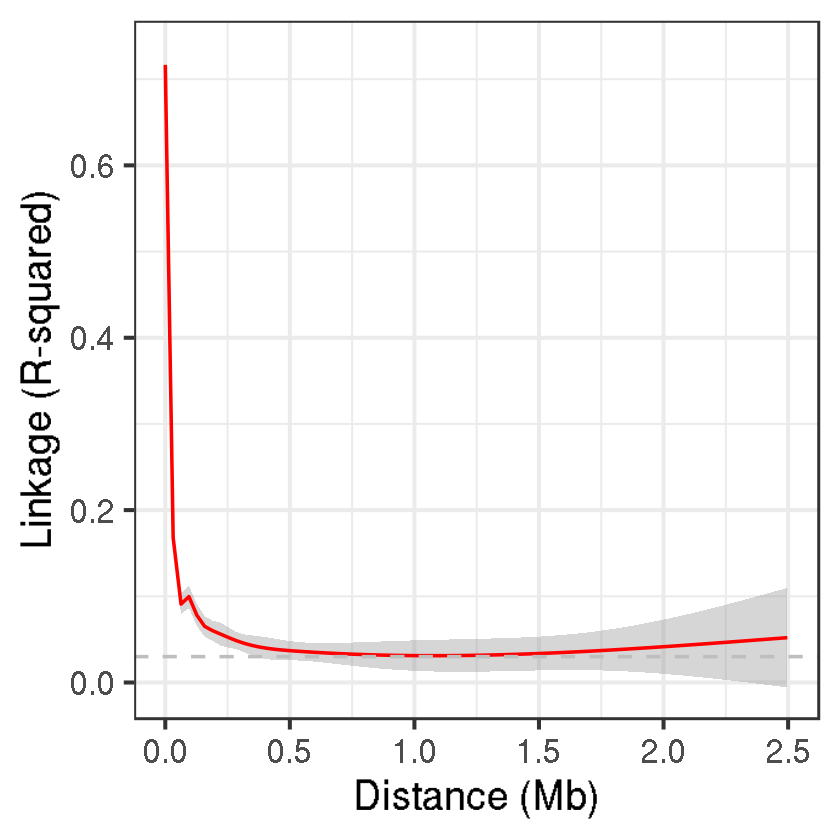

In [30]:
p = ggplot(dist.cntrl %>% sample_n(10000), aes(x = dist, y = Rsq)) +
    geom_smooth(colour = 'red') +
    xlim(0,2.5) +
    ylab('Linkage (R-squared)') +
    theme_bw(base_size = 25) +
    xlab('Distance (Mb)') +
    geom_hline(yintercept = 0.03, linetype = 'dashed', colour = 'grey', size = 1)

p
ggsave( '../Figures/ClusterLinkage/Linkage.IntraClust.pdf', p, width = 10, height = 10)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 293 rows containing non-finite values (`stat_smooth()`).”
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 293 rows containing non-finite values (`stat_smooth()`).”


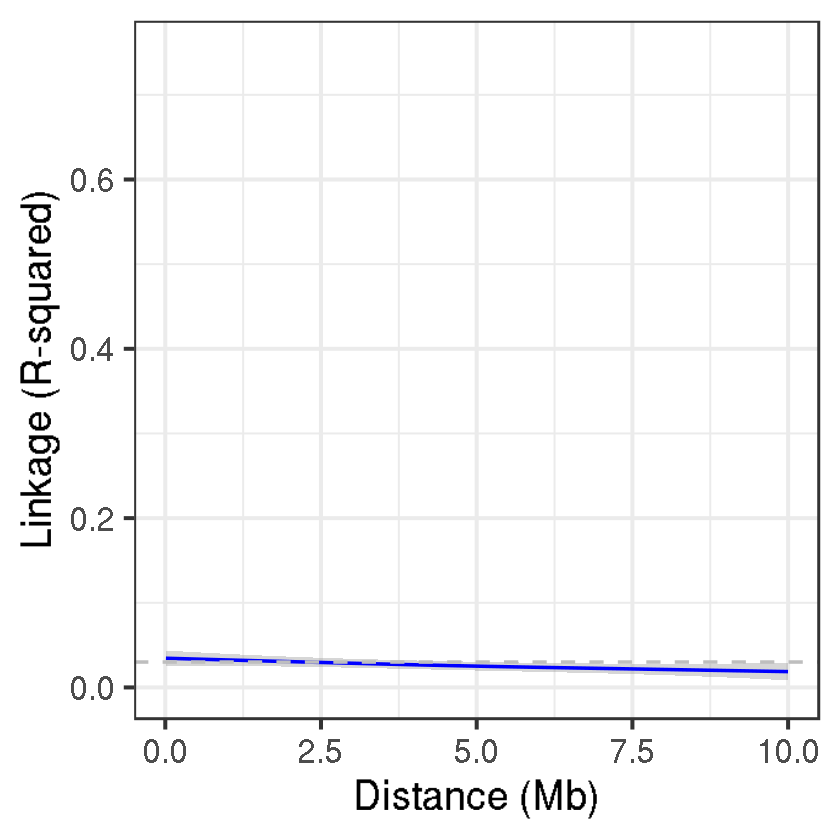

In [29]:
p = ggplot(dist.comp %>% sample_n(1000), aes(x = dist, y = Rsq)) +
    geom_smooth(colour = 'blue') +
    xlim(0,10) +
    theme_bw(base_size = 25) +
    ylim(0, 0.75) +
    ylab('Linkage (R-squared)') +
    xlab('Distance (Mb)') +
    geom_hline(yintercept = 0.03, linetype = 'dashed', colour = 'grey', size = 1)

p
ggsave( '../Figures/ClusterLinkage/Linkage.InterClust.pdf', p, width = 10, height = 10)

# SNP pair linkage between top 50 SNPs of each cluster and adjacent clusters

In [ ]:
#1) Associate snps to clusters

df.clust = read.csv('df.clust.orch2021.csv')
df.sig = read.csv('./df.sig.SpToFall.csv')
df.snps = df.sig %>% filter(sigLevel > 2)
df.snps = do.call(rbind,lapply(1:nrow(df.clust),function(cl){
            df.snps %>% merge(df.clust[cl,] %>% dplyr::select(cl,comparison,chrom,startPos,endPos),by=c("comparison","chrom")) %>%
            filter(pos>=startPos,pos<=endPos)
            }))

In [ ]:
#2) Get top 50 snps per cluster
top_snps <- df.snps %>%
  group_by(cl) %>%
  arrange(FDR) %>%
  slice_head(n = 50) %>%
  ungroup()

In [ ]:
#3) Get snp inter cluster snp pairs
df.pairs = top_snps %>% find_snp_pairs(maxDist=1000000) %>% filter(pairType=="inter")

In [ ]:
#4) Get Rsq between snp pairs
for (chr in c("2L", "2R", '3L', '3R', 'X')){
                snpFile= paste0("~/dpetrov/MarkB/Orchard2021Data/snptables/Orchard2021/inbredv2_withHets.orch2021.", chr, ".snpTable.numeric")
                df.pairs.chrom = df.pairs %>% filter(chrom == chr)
                snppairs = calc_Rsq_for_snp_pairs(df.pairs.chrom, ncores = 16, snpFile)
                snppairs = snppairs %>%
                    dplyr::select(-snp1.cl,-snp2.cl)
                write.csv(snppairs, paste0('df.pairs.',chr, '.1MbDist.csv'))
            }
files = list.files(pattern = 'df.pairs')
data = data.frame()
for (f in files){
    df = read.csv(f)
    chrom = strsplit(f, '[.]')[[1]][3]
    mean.rsq = mean(na.omit(df$Rsq))
    med.rsq = median(na.omit(df$Rsq))
    d = cbind(chrom, mean.rsq, med.rsq)
    data = rbind(data, d)
}
df.pairs = data



In [2]:
#5) Produce eCDFs and plot  for each chromosomal arm and then genome-wide
df.2l = read.csv('./df.pairs.2L.1MbDist.csv')
df.2r = read.csv('./df.pairs.2R.1MbDist.csv')
df.3l = read.csv('./df.pairs.3L.1MbDist.csv')
df.3r = read.csv('./df.pairs.3R.1MbDist.csv')
df.x = read.csv('./df.pairs.X.1MbDist.csv')

In [33]:
CDF.2l <- ecdf(df.2l$Rsq)
CDF.2r <- ecdf(df.2r$Rsq)
CDF.3l <- ecdf(df.3l$Rsq)
CDF.3r <- ecdf(df.3r$Rsq)
CDF.x <- ecdf(df.x$Rsq)
x <- seq(0, 1, length.out = 1000000)
y.2l <- CDF.2l(x)
y.2r <- CDF.2r(x)
y.3l <- CDF.3l(x)
y.3r <- CDF.3r(x)
y.x <- CDF.x(x)


In [34]:
plot_data <- data.frame(x = x, y = y.2l)
p.2l = ggplot(plot_data, aes(x, y)) +
  geom_step() +
  labs(x = "Linkage (R-squared)", y = "Cumulative Probability", title = "2L") +
    theme_bw(base_size = 15) 
ggsave('../Figures/ClusterLinkage/TopSNPLinkage.CDFs.2L.pdf', p.2l, height = 12, width = 12)

plot_data <- data.frame(x = x, y = y.2r)
p.2r = ggplot(plot_data, aes(x, y)) +
  geom_step() +
  labs(x = "Linkage (R-squared)", y = "Cumulative Probability", title = "2R") +
    theme_bw(base_size = 15) 
ggsave('../Figures/ClusterLinkage/TopSNPLinkage.CDFs.2R.pdf', p.2r, height = 12, width = 12)


plot_data <- data.frame(x = x, y = y.3l)
p.3l =ggplot(plot_data, aes(x, y)) +
  geom_step() +
  labs(x = "Linkage (R-squared)", y = "Cumulative Probability", title = "3L") +
    theme_bw(base_size = 15) 
ggsave('../Figures/ClusterLinkage/TopSNPLinkage.CDFs.3l.pdf', p.3l, height = 12, width = 12)


plot_data <- data.frame(x = x, y = y.3r)
p.3r =ggplot(plot_data, aes(x, y))  +
  geom_step() +
  labs(x = "Linkage (R-squared)", y = "Cumulative Probability", title = "3R") +
    theme_bw(base_size = 15) 
ggsave('../Figures/ClusterLinkage/TopSNPLinkage.CDFs.3R.pdf', p.3r, height = 12, width = 12)


plot_data <- data.frame(x = x, y = y.x)
p.x =ggplot(plot_data, aes(x, y))  +
  geom_step() +
  labs(x = "Linkage (R-squared)", y = "Cumulative Probability", title = "x") +
    theme_bw(base_size = 15) 
ggsave('../Figures/ClusterLinkage/TopSNPLinkage.CDFs.x.pdf', p.x, height = 12, width = 12)


In [3]:
df.2l$X = 1:nrow(df.2l)

In [4]:
#Get-genome wide data and plot
df.inter.pairs = rbind(df.2l, df.2r, df.3l, df.3r, df.x)
CDF.inter <- ecdf(df.inter.pairs$Rsq)


In [6]:
df.inter.pairs %>% group_by(chrom) %>% summarise(mean.rsq = mean(na.omit(Rsq)))

chrom,mean.rsq
<fct>,<dbl>
2L,0.03447901
2R,0.02314527
3L,0.02826044
3R,0.02762475
X,0.02663163


In [8]:
mean(na.omit(df.inter.pairs$Rsq))

[1] 0.02934189

In [46]:
CDF.inter <- ecdf(df.inter.pairs$Rsq)
rsq <- seq(0, 1, length.out = 1000000)
y.inter <- CDF.inter(rsq)


In [48]:
y.inter = as.data.frame(y.inter)
names(y.inter) = c('Density')
y.inter$Rsq = rsq
y.inter$type = 'Inter'

In [51]:
p = ggplot(y.inter, aes(x = Rsq, y = Density)) +
    geom_step() +
    theme_bw(base_size = 15) +
    xlab('Linkage (R-squared)') +
    ylab('Cummulative Probability') +
    ggtitle('Genome') +
    theme(legend.position="none")

In [54]:
library(cowplot)
p.meta = plot_grid(p.2l, p.2r  , p.3l, p.3r, p.x, p, nrow = 3)
ggsave('../Figures/ClusterLinkage/TopSNPLinkage.CDFs.Meta.pdf', p.meta, height = 12, width = 12)

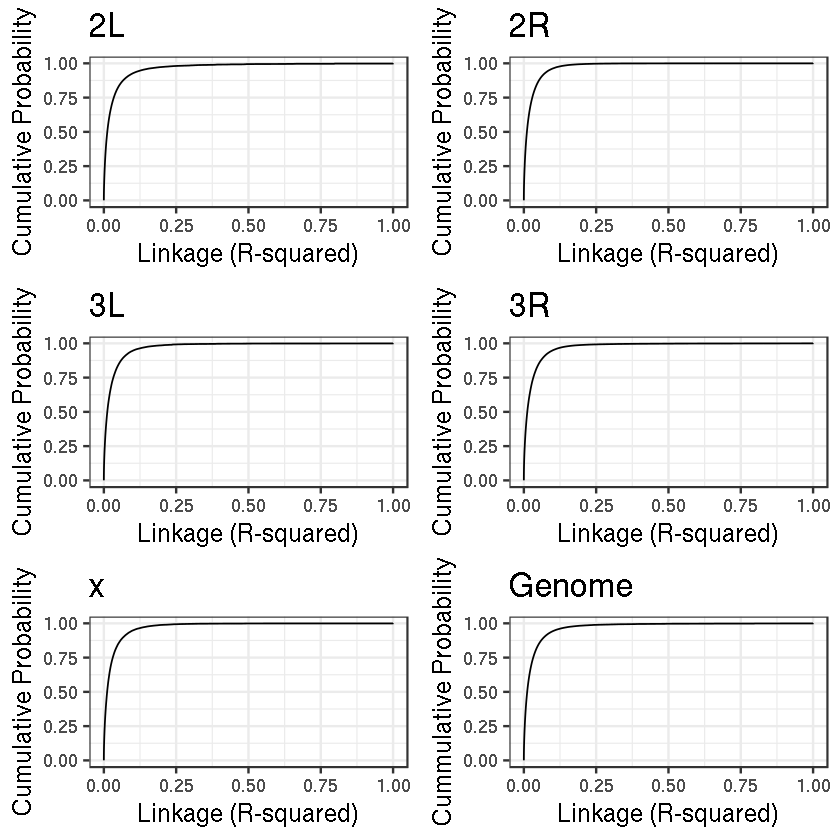

In [55]:
p.meta